In [113]:
#preprocessing
import numpy as np
import random

#regressor

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#plotting
import matplotlib.pyplot as plt

#stats
import scipy.stats as stats

## Load Data

In [2]:
%run loading_data.ipynb

In [3]:
sub_data = load_txt()

Subject Data Loaded


In [4]:
atlas = load_atlas()

/tmp/ipykernel_422/1030149754.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas = image.threshold_img(atlas, "99.5%")


atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


In [5]:
unrestricted_data = load_unrestricted()

unrestricted_data loaded


In [6]:
restricted_data = load_restricted()

restricted_data loaded


In [7]:
handedness = get_handedness()

restricted_data loaded


## Extract Features

### Correlation Matrices

In [56]:
#create all correlation matrices
matrices = []
for i in range(len(sub_data)):
    matrices.append(np.corrcoef(sub_data[i].T))
matrices = np.array(matrices)

## Regressor on all data (balanced, new predictor for all chunks)

### Balancing the dataset

In [82]:
threshold = 0
handedness = handedness.reset_index()
left_df = handedness[handedness['Handedness'] < threshold]
right_df = handedness[handedness['Handedness'] > threshold]

In [83]:
handedness

,index,Subject,Handedness
0,0,645551,90
1,1,135629,90
2,2,647858,70
3,3,686969,60
4,4,115724,100
...,...,...,...
998,998,969476,70
999,999,965367,100
1000,1000,120414,35
1001,1001,769064,80


In [84]:
#Random Sampling
sample_size = len(left_df)
num_samples = len(right_df) // sample_size


# Shuffle the indices randomly
random.seed(0)
shuffled_indices = np.random.permutation(len(right_df))


In [117]:
all_coef = []
all_pred = []
all_test = []

chunks = [right_df.iloc[shuffled_indices[i * sample_size: (i + 1) * sample_size]] for i in range(num_samples)]
for i in range(len(chunks)):
    idx = np.append(np.array(left_df.index), np.array(chunks[i].index))
    matrix_chunk = matrices[idx]

    #getting top triangle of all matrices
    dataX = []
    for m in matrix_chunk:
        top_corner = np.triu(m, 1)
        just_data = top_corner[top_corner != 0]
        arr_data = just_data.flatten()
        dataX.append(arr_data)

    dataY = np.array(handedness.loc[idx]['Handedness'])

    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

    # Create a Ridge regression model with alpha = 1.0 (default)
    ridge = Ridge(alpha=0.01) 
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    all_pred.append(y_pred)
    all_test.append(y_test)
    all_coef.append(ridge.coef_)
    

### Analysis

/tmp/ipykernel_422/3605924118.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_pred, labels=[f'Chunk {i}' for i in range(len(all_pred))])


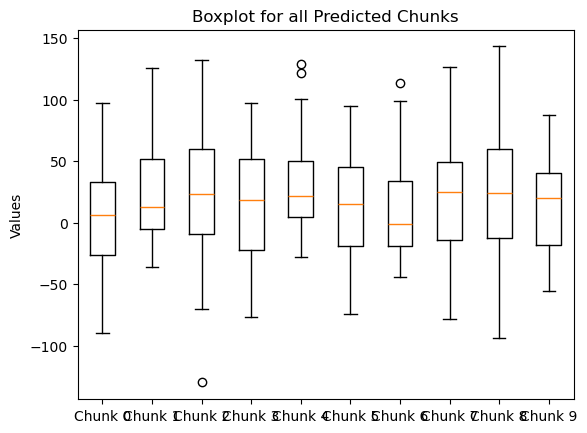

In [120]:
# Create boxplot
plt.boxplot(all_pred, labels=[f'Chunk {i}' for i in range(len(all_pred))])

# Add title
plt.title("Boxplot for all Predicted Chunks")
plt.ylabel("Values")

plt.show()

/tmp/ipykernel_422/817764619.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_coef, labels=[f'Chunk {i}' for i in range(len(all_pred))])


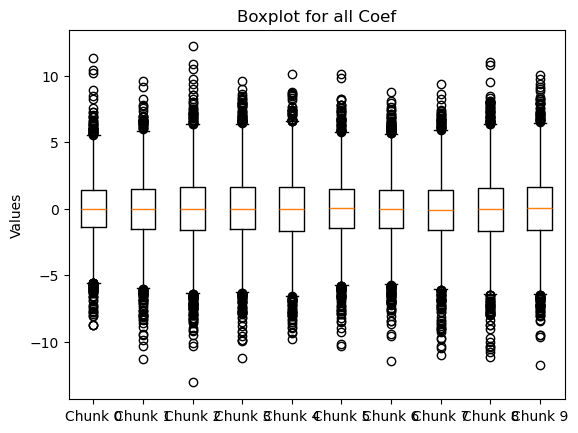

In [121]:
# Create boxplot
plt.boxplot(all_coef, labels=[f'Chunk {i}' for i in range(len(all_pred))])

# Add title
plt.title("Boxplot for all Coef")
plt.ylabel("Values")

plt.show()

<h1 style='color:red'>**Idea** use the outliers to find areas best for prediction</h1>

Model coefficients look too similar, I doubt anything would change if we average them.

In [130]:
all_pred_flat = np.array(all_pred).flatten()
all_test_flat = np.array(all_test).flatten()

y_test_binary = (all_test_flat > threshold).astype(int)
y_pred_binary = (all_pred_flat > threshold).astype(int)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 76 114]
 [ 57 113]]


In [131]:
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('Precision', precision)
print('Recall', recall)

Precision 0.4977973568281938
Recall 0.6647058823529411


## Using one chunk to train and rest to test

In [139]:
chunks = [right_df.iloc[shuffled_indices[i * sample_size: (i + 1) * sample_size]] for i in range(num_samples)]
allX = []
allY = []

for i in range(len(chunks)):
    idx = np.append(np.array(left_df.index), np.array(chunks[i].index))
    matrix_chunk = matrices[idx]
    
    #getting top triangle of all matrices
    dataX = []
    for m in matrix_chunk:
        top_corner = np.triu(m, 1)
        just_data = top_corner[top_corner != 0]
        arr_data = just_data.flatten()
        dataX.append(arr_data)
    
    dataY = np.array(handedness.loc[idx]['Handedness'])

    allX.append(dataX)
    allY.append(dataY)

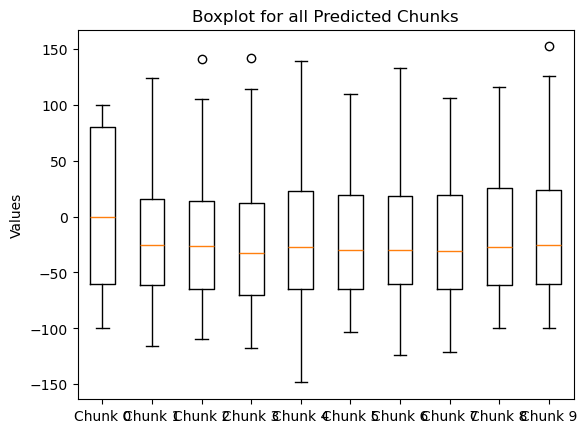

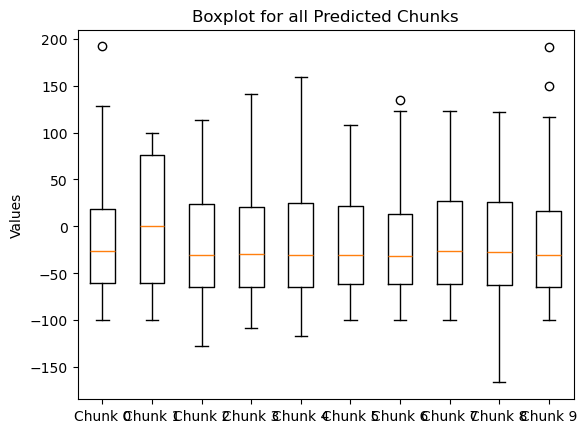

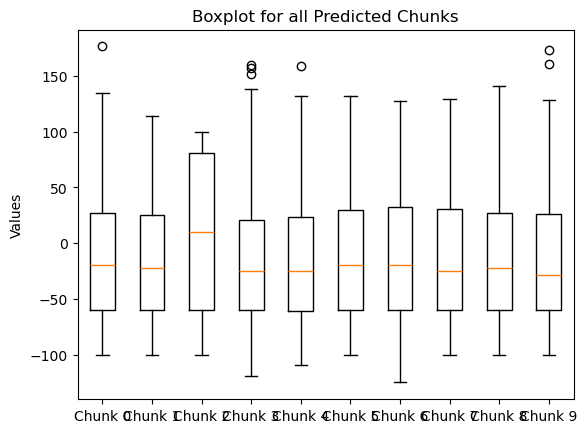

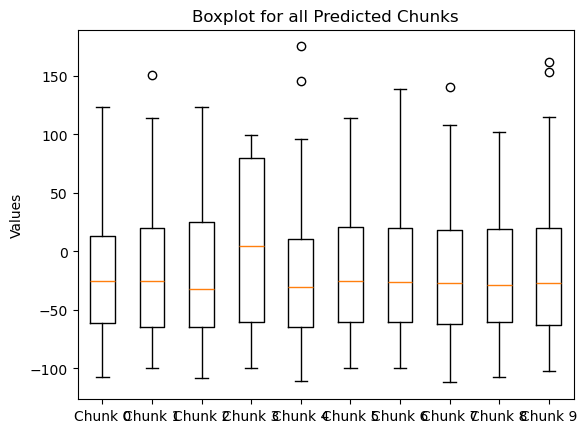

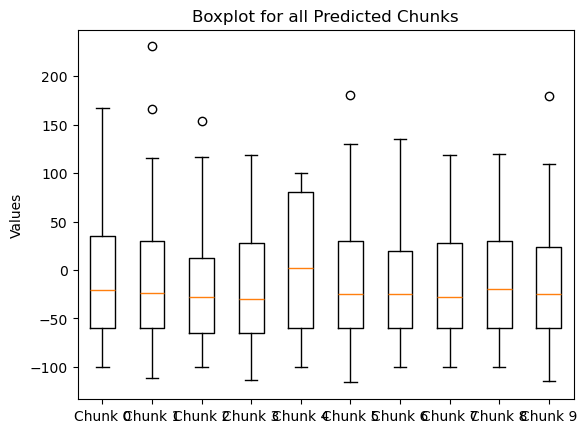

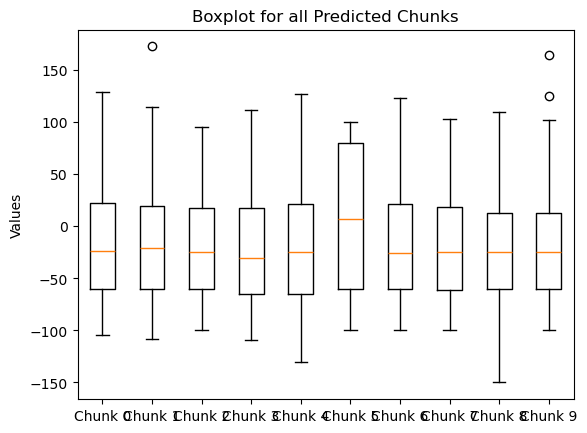

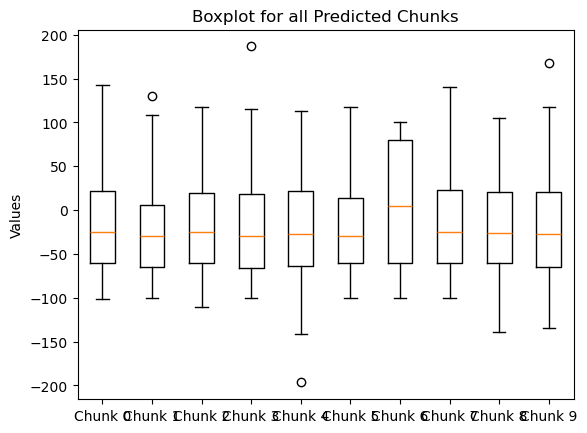

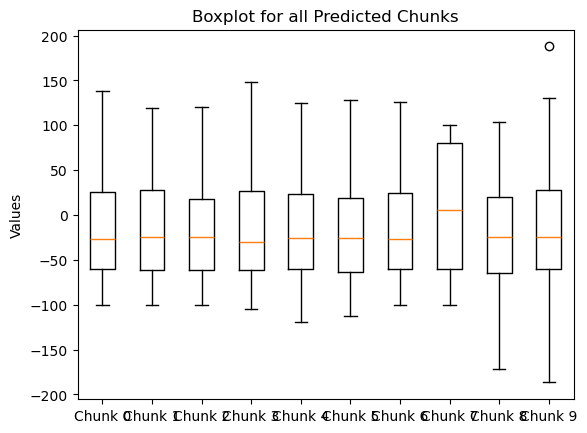

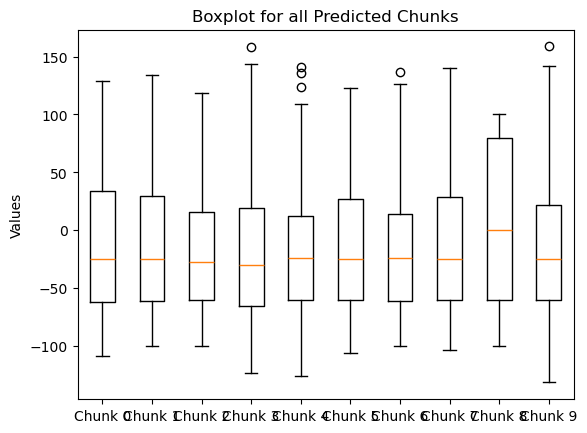

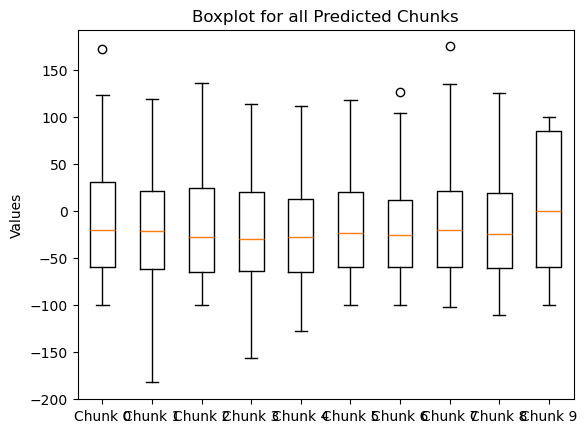

In [143]:
for i in range(len(allX)):
    dataX = allX[i]
    dataY = allY[i]
    # Create a Ridge regression model with alpha = 1.0 (default)
    ridge = Ridge(alpha=0.01) 
    ridge.fit(dataX, dataY)
    
    all_pred = []
    for i in range(len(allX)):
        y_pred = ridge.predict(allX[i])
    
        all_pred.append(y_pred)

    # Create boxplot
    plt.boxplot(all_pred, tick_labels=[f'Chunk {i}' for i in range(len(all_pred))])
    
    
    # Add title
    plt.title("Boxplot for all Predicted Chunks")
    plt.ylabel("Values")
    
    plt.show()